In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter, defaultdict
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

%matplotlib inline

GPU is available
GPU is available


Using TensorFlow backend.


# Experiment 1a

In [4]:
# define experiment
exp='/exp_1'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [7]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16728
Number of test source-target pairs: 4182


In [8]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['look', 'left', 'thrice', 'after', 'turn', 'opposite', 'left']
Action: ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK']


In [9]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'right', 'thrice', 'after', 'jump', 'right']
Action: ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']


## Distribution of command and action sequences across datasets

In [19]:
def compute_distributions(sequences:list):
    distrib = Counter(list(map(lambda seq: len(seq), sequences)))
    #distrib_sorted = dict(sorted(distrib.items(), key=lambda kv:kv[0], reverse=False))
    return distrib.items() #distrib_sorted.items()

def show_seq_distributions(train_sequences:list, test_sequences:list, language:str):
    train_seq_lengths, train_seq_length_freqs = zip(*compute_distributions(train_sequences))
    test_seq_lengths, test_seq_length_freqs = zip(*compute_distributions(test_sequences))
    plt.figure(figsize=(8, 4) if language=='target' or language=='action' else (6, 4))
    plt.bar(train_seq_lengths, train_seq_length_freqs, color='blue', width=1.0, edgecolor='black', alpha=0.3, label='train')
    plt.bar(test_seq_lengths, test_seq_length_freqs, color='orange', width=1.0, edgecolor='black', alpha=0.3, label='test')
    plt.xlabel('Sequence lengths', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of {} sequence lengths'.format(language), fontsize=13)
    plt.legend(fancybox=True,shadow=True,loc='upper right' if language=='target' or language=='action' else 'upper left',fontsize=10)
    plt.savefig('./paper/plots/descriptive_stats/distribution_seq_lengths' + '_' + language)
    plt.show()

### Commands

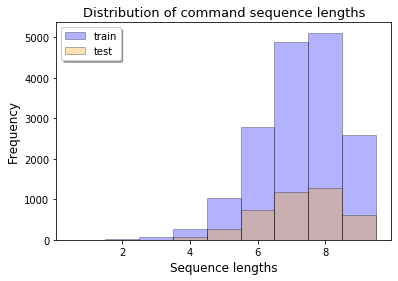

In [20]:
show_seq_distributions(cmds_train, cmds_test, 'command')

### Actions

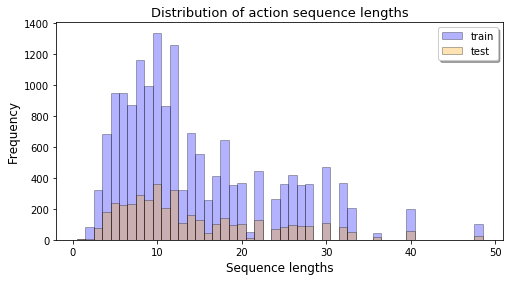

In [21]:
show_seq_distributions(acts_train, acts_test, 'action')

## Prepare data

In [22]:
cmds_train, acts_train, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
cmds_test, acts_test, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)

In [25]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
test_dl = create_batches(cmds_test, acts_test, input_lengths_test, batch_size=batch_size, split='test')

In [26]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_sizes = [10, 20]

# size of hidden units
hidden_sizes = [50, 100]

# number of layers
layer_sizes = [1, 2]

# layer dropout rates
dropout_rates = [0.25, 0.5]

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = True

# number of epochs
n_epochs = 10 # 10-15 epochs (20.000 iterations each) seem to be sufficient to let models converge

## Grid search over specified hyperparameter space

In [27]:
def grid_search(embedding_sizes:list, hidden_sizes:list, layer_sizes:list, dropout_rates:list, lr:float, n_epochs:int):
    in_size = len(w2i_cmds) # source language (i.e., commands) vocabulary size |V_source|
    out_size = len(w2i_acts) # target language (i.e., actions) vocabulary size |V_target|
    batch_size = 32
    grid_results = defaultdict(dict)
    for emb_size in embedding_sizes:
        for hidden_size in hidden_sizes:
            for layer_size in layer_sizes:
                for dropout_rate in dropout_rates:
                    # instantiate models
                    encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=False)
                    decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)
                    # move models to GPU, if nvidia GPU is available (faster computation)
                    encoder.cuda()
                    decoder.cuda()
                    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts,
                                                                       encoder, decoder, epochs=n_epochs,
                                                                       batch_size=batch_size, learning_rate=lr)
                    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, batch_size=batch_size)
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_accs'] = train_accs
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_losses'] = train_losses
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['test_acc'] = test_acc
    return grid_results

In [ ]:
grid_results = grid_search(emb_sizes, hidden_sizes, layer_sizes, dropout_rates, lr, n_epochs)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.0768085068318902
Acc: 0.0

Command: look opposite right twice after jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT

True sent length: 16
Pred sent length: 16



## Debugging

In [16]:
## Instantiate models ##

encoder = EncoderLSTM(in_size, emb_size, hidden_size, n_layers, dropout=dropout_p, bidir=bidir)
decoder = DecoderLSTM(emb_size, hidden_size, out_size, n_layers, dropout=dropout_p)

In [17]:
encoder.cuda()

EncoderLSTM(
  (embedding): Embedding(16, 20, padding_idx=0)
  (lstm): LSTM(20, 100, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
)

In [18]:
# move models to GPU, if GPU is available (for faster computation)
decoder.cuda()

DecoderLSTM(
  (embedding): Embedding(9, 20, padding_idx=0)
  (lstm): LSTM(20, 100, num_layers=2, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=9, bias=True)
)

### Training

In [19]:
#train_losses, train_accs, encoder, decoder = train(train_dl,
#                                                   w2i_cmds, w2i_acts,
#                                                   i2w_cmds, i2w_acts,
#                                                   encoder, decoder,
#                                                   epochs=n_epochs,
#                                                   batch_size=batch_size,
#                                                   learning_rate=lr)


Epoch:   0%|                                                                                     | 0/8 [00:00<?, ?it/s]

Loss: 0.7272494459178025
Acc: 0.00031146179401993354

Command: turn opposite right twice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 11
Pred sent length: 11

Loss: 0.4614571475745919
Acc: 0.004679700499168053

Command: walk opposite left thrice and jump around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_JUMP 

Epoch:  12%|█████████▌                                                                  | 1/8 [04:26<31:05, 266.56s/it]

Loss: 0.3265364239141345
Acc: 0.044954318936877076

Command: jump around left thrice and jump around right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT

Epoch:  25%|███████████████████                                                         | 2/8 [08:51<26:36, 266.01s/it]

Loss: 0.6988258667614814
Acc: 0.20816029900332225

Command: jump around left twice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS> <EOS> <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.17249292337700076
Acc: 0.2720465890183028

Command: walk opposite right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TU

Epoch:  38%|████████████████████████████▌                                               | 3/8 [13:08<21:56, 263.33s/it]

Loss: 0.18797569599565725
Acc: 0.45598006644518274

Command: jump opposite right thrice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.4898946293315655
Acc: 0.5078514975041597

Command: walk around left thrice and walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_T

Epoch:  50%|██████████████████████████████████████                                      | 4/8 [17:18<17:17, 259.44s/it]

Loss: 0.09546938677071974
Acc: 0.6815822259136213

Command: look around right thrice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.055357

Epoch:  62%|███████████████████████████████████████████████▌                            | 5/8 [21:27<12:48, 256.14s/it]

Loss: 0.09333841742414221
Acc: 0.8429194352159468

Command: walk around right thrice after walk around right thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN

Epoch:  75%|█████████████████████████████████████████████████████████                   | 6/8 [25:34<08:27, 253.59s/it]

Loss: 0.01818803278752746
Acc: 0.9476744186046512

Command: turn around left twice and walk around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 25
Pred sent length: 25

Loss: 0.007998024208242433
Acc: 0.959182612312812

Command: look around left thrice and look around right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TU

Epoch:  88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [29:46<04:12, 252.95s/it]

Loss: 0.002499002828946286
Acc: 0.9699958471760798

Command: turn opposite right thrice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.013377061944350562
Acc: 0.9700499168053245

Command: walk around right thrice and jump around left twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_T

Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 8/8 [33:53<00:00, 254.24s/it]


### Testing

In [20]:
#test_acc = test(test_dl,
#                w2i_cmds, w2i_acts, 
#                i2w_cmds, i2w_acts, 
#                encoder, decoder,
#                batch_size=batch_size)

Current test acc: 0.977328431372549

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9764851485148515

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT 